In [1]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import matplotlib
import matplotlib.colors as colors
import metpy.calc as mpc
import xarray as xr
from utils import *
from math import log10, floor
import cftime

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# simulation parameters
rot = False
small_earth_fact = 60 
center_lon = 120

In [3]:
# Information about the paths
model = 'SE' # 'SE' or 'FV3' or 'MPAS'
res = 'ne30'  # 'ne30' or 'C96' or '120' for 1-deg and 'ne60' or 'C192' or '60' for 0.5 deg
vert = 'nonhydrostatic'

# Edit this to your own case name
case = f'dcmip25_squall_{model.lower()}_{res}'

# Modify the following according to your naming convention
nc_file = case + '.cam.h0i.0001-01-01-00000.nc'

# Define the base root to the data,
# add your username
username = 'nandrosk'
run_base = f'/glade/work/{username}/dcmip25/'
output_base = f'/glade/u/home/{username}/'

# Automatically set some paths
#run_path = run_base + case + '/run/' + nc_file
run_path = run_base + case + '/' + nc_file

# output_dir = f'{CAM_dirname}/plotting/'
# output_file = output_base + output_dir
print(run_path)

/glade/work/nandrosk/dcmip25/dcmip25_squall_se_ne30/dcmip25_squall_se_ne30.cam.h0i.0001-01-01-00000.nc


In [4]:
ds = xr.open_dataset(run_path)

In [5]:
# Extract the data
nc = Dataset(run_path)
time_stamps = nc['time'][:]
lats = nc['lat'][:] 
lons = nc['lon'][:] 
levs = nc['lev'][:]

print(f'There are {len(time_stamps)} time samples')
print(f'{len(lats)} latitiude points, {len(lons)} longitude points')

There are 37 time samples
181 latitiude points, 360 longitude points


In [6]:
# Specify the altitude, field and times you want to plot
z_val = 2500 # in metres for 3d fields
two_d = True # 2d fields - PRECT, TMQ, TMRAINQM, TMCLDLIQ, composite_RAD_REF
field = 'composite_RAD_REF' # 3d fields - T or U or V or W or div or vor or Q or RAD_REF or composite_RAD_REF
t_idxs = [9, 18, 27, 36] # Each index is 5 minutes

In [7]:
# Crop to the subdomain of interest

lon_crop_left = 70.
lon_crop_right = 250.
lon_ticks = np.linspace(80, 220, 8) # Plotting ticks

lat_crop_up = 40.
lat_crop_down = -40.
lat_ticks = np.linspace(-40,40,8) # Plotting ticks


lon_inds = np.where((lons > lon_crop_left) & (lons < lon_crop_right))[0]
lat_inds = np.where((lats > lat_crop_down) & (lats < lat_crop_up))[0]

print(f'Crop is of size, {len(lat_inds)} lat vals and {len(lon_inds)} lon vals')

lat_slice = lats[lat_inds] 
lon_slice = lons[lon_inds] 
LON_subset, LAT_subset = np.meshgrid(lon_slice, lat_slice)

Crop is of size, 79 lat vals and 180 lon vals


In [8]:
# Interpolate the 3d data at each time index:
if (not two_d):
    if (field == "vor" or field == "div"):
        uv = np.zeros((len(t_idxs), 2, len(lat_slice), len(lon_slice)))
        for i in range(len(t_idxs)):
            uv[i] = z_interp_uv(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc['U'][t_idxs[i], :, lat_inds, lon_inds], nc['V'][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
            print('interpolated time ' + str(i+1))
    elif (field == "W"):
        interp_field_vals = np.zeros((len(t_idxs), len(lat_slice), len(lon_slice)))
        if (model == 'MPAS'):
            for i in range(len(t_idxs)): # still needs to be tested
                interp_field_vals[i] = z_interp(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc['w'][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
                print('interpolated time ' + str(i+1))
        else:
            if (vert == 'hydrostatic'):
                for i in range(len(t_idxs)):
                    interp_field_vals[i] = z_interp_w_hydrostatic(nc, t_idxs[i], lon_inds, lat_inds, z_val)
                    print('interpolated time ' + str(i+1))
            else: 
                for i in range(len(t_idxs)):
                    interp_field_vals[i] = z_interp_w_nonhydro(nc, t_idxs[i], lon_inds, lat_inds, z_val)
                    print('interpolated time ' + str(i+1))
    else:
        interp_field_vals = np.zeros((len(t_idxs), len(lat_slice), len(lon_slice)))
        for i in range(len(t_idxs)):
            interp_field_vals[i] = z_interp(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc[field][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
            print('interpolated time ' + str(i+1))
else:
    # 2d, no interpolation needed
    if field == 'composite_RAD_REF':
        # grab RAD_REF but keep all levs, we'll process them in the next step
        interp_field_vals = nc[field.split('_',1)[1]][t_idxs, :, lat_inds, lon_inds] 
    else:
        interp_field_vals = nc[field][t_idxs, lat_inds, lon_inds]

In [9]:
if (field == "PRECT"):
    field_vals = 1000*60*60*24 * interp_field_vals
elif field == "vor":
    # compute vorticity
    uv_ds = xr.Dataset(data_vars = dict(
        U=(['time', 'lat', 'lon'], uv[:,0]), V=(['time', 'lat', 'lon'], uv[:,1])), 
        coords = dict(time=time_stamps[t_idxs], lat=lat_slice, lon=lon_slice))
    uv_ds['U'].attrs["units"] = "m/s"
    uv_ds['V'].attrs["units"] = "m/s"
    field_vals = small_earth_fact*mpc.vorticity(uv_ds['U'], uv_ds['V'])
elif field == "div":
    # compute divergence
    uv_ds = xr.Dataset(data_vars = dict(
        U=(['time', 'lat', 'lon'], uv[:,0]), V=(['time', 'lat', 'lon'], uv[:,1])), 
        coords = dict(time=time_stamps[t_idxs], lat=lat_slice, lon=lon_slice))
    uv_ds['U'].attrs["units"] = "m/s"
    uv_ds['V'].attrs["units"] = "m/s"
    field_vals = small_earth_fact*mpc.divergence(uv_ds['U'], uv_ds['V'])
elif field == 'composite_RAD_REF':
    field_vals = np.max(interp_field_vals, axis=1)
else:
    field_vals = interp_field_vals


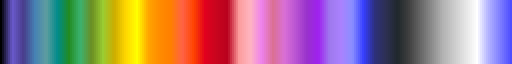

In [10]:
# define RAD_REF colorbar:
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
###################################################
#                                                 #
#     Define Ben's Base Reflectivity Colormap:    #
#   https://www.wxtools.org/reflectivity/bens-br  #
#                                                 #
###################################################

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
# dictionary from RGB color to the corresponding DBZ value
colors_dict = {
    (0, 0, 0): -10,
    (106, 90, 205): 10,
    (72, 61, 139): 12,
    (70, 130, 180): 14,
    (95, 158, 160): 16,
    (0, 139, 139): 18,
    (34, 139, 34): 20,
    (60, 179, 113): 22,
    (107, 142, 35): 24,
    (154, 205, 50): 26,
    (205, 173, 0): 28,
    (255, 215, 0): 30,
    (255, 255, 0): 32,
    (255, 165, 0): 34,
    (255, 140, 0): 36,
    (255, 127, 0): 38,
    (255, 99, 71): 40,
    (255, 69, 0): 42,
    (226, 1, 30): 44,
    (200, 6, 30): 46,
    (185, 1, 30): 48,
    (252, 156, 156): 50,
    (255, 182, 193): 52,
    (238, 130, 238): 54,
    (219, 112, 147): 56,
    (218, 112, 214): 58,
    (186, 85, 211): 60,
    (153, 50, 204): 62,
    (160, 32, 240): 64,
    (159, 121, 238): 66,
    (171, 130, 255): 68,
    (138, 143, 255): 70,
    (54, 62, 255): 72,
    (45, 48, 122): 74,
    (45, 48, 82): 76,
    (32, 40, 44): 78,
    (0, 0, 0): 80,  # Note: The dBZ of 80 uses the same color as -10 DBZ
    (64, 64, 64): 82,
    (102, 102, 102): 84,
    (140, 140, 140): 86,
    (179, 179, 179): 88,
    (204, 204, 204): 90,
    (230, 230, 230): 92,
    (255, 255, 255): 94,
    (179, 179, 255): 96,
    (128, 128, 255): 98,
    (77, 77, 255): 100
    #(240, 200, 240, 4): 100,  # alternative solid color upper bound, requires alpha
    #(250, 250, 250, 5): 100,  # alternative solid color upper bound, requires alpha
}


# Extracting RGB values
rgb_values = np.array(list(colors_dict.keys()))/255

# Extracting DBZ values
dbz_values = np.array(list(colors_dict.values()))

# make a discete, listed, colormap
rr_cmap_disc = ListedColormap(rgb_values,name="Ben's Base Reflectivity (Discrete)")

# make a continuous colormap from the discrete set of colors
rr_cmap_cont = LinearSegmentedColormap.from_list("Ben's Base Reflectivity (Continuous)",rgb_values)
rr_cmap_cont

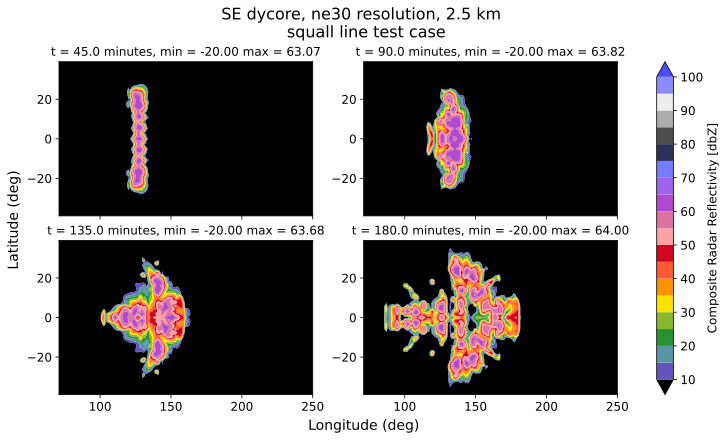

In [11]:
# Make the plot!
# fig, axes = plt.subplots(len(t_idxs),1, figsize=(6.5,10.0*len(t_idxs)/4.0), sharex=True, layout='constrained')
fig, axes = plt.subplots(2,2, figsize=(10.0,6.0), sharex=True, layout='constrained')

title_size=16
label_size=14
small_size=12
round_dig = 2

fix_minmax = True

# For the title
dycore_res = f'{model} {res}'

# Feel free to add additional fields
if field == 'T':
    title = 'Temperature perturbation'
    cb_label = '$T - T_0$ [K]'
    min = -2
    max = 5
elif field == 'U':
    title = 'Normalised zonal velocity perturbation'
    cb_label = '$(u(t) - u_0)/u_0$ [m/s]'
    min = -1.5
    max = 0.6
elif field == 'V':
    title = "Meridional velocity"
    cb_label = '$v(t)$ [m/s]'
    min = -9
    max = 9
elif field == 'W':
    title = "Vertical velocity"
    cb_label = '$w(t)$ [m/s]'
    min = -14
    max = 14
elif field == "vor":
    title = "Relative vorticity"
    cb_label = '$\zeta(t)$ [1/s]'
    round_dig = 6
    min = -0.00014*small_earth_fact
    max = 0.00016*small_earth_fact
elif field == "div":
    title = "Fluid divergence"
    cb_label = '$\sigma(t)$ [1/s]'
    round_dig = 6
    min = -0.00003*small_earth_fact
    max = 0.00003*small_earth_fact
elif field == "Q":
    title = "Specific humidity"
    cb_label = 'mixing ratio'
    round_dig = 3
    min = 0
    max = 1
elif field == "PRECT":
    title = "Total precipitation rate"
    cb_label = '[mm/day]'
    round_dig = 0
    min = 0
    max = 0.01
elif field == "TMCLDLIQ":
    title = "Vertically integrated cloud liquid"
    cb_label = '$[kg/m^2]$'
    round_dig = 2
    min = 0
    max = 20
elif field == "TMRAINQM":
    title = "Column rain liquid"
    cb_label = '$[kg/m^2]$'
    min = 0
    max = 100
elif field == 'RAD_REF' or field == 'composite_RAD_REF':
    title = "Radar Reflectivity"
    if field == 'composite_RAD_REF':
        title = 'Composite ' + title
    cb_label = '[dbZ]'
    min = 10
    max = 100

# for the color map
valmin = np.nanmin(field_vals)
valmax = np.nanmax(field_vals)
if ((-1e-10 > valmin) and (1e-10 < valmax)):
    if fix_minmax:
        norm = MidpointNormalize(midpoint = 0, vmin = min, vmax = max)
    else:
        norm = MidpointNormalize(midpoint = 0, vmin = valmin, vmax = valmax)
    cmap_choice = 'RdBu_r'
elif (valmin < 1e-10):
    cmap_choice = "Blues"
    if (fix_minmax):
        norm = colors.Normalize(vmin=min, vmax=max)
    else:
        norm = colors.Normalize(vmin=valmin, vmax=valmax)       
else:
    if (fix_minmax):
        norm = colors.Normalize(vmin=min, vmax=max)
    else:
        norm = colors.Normalize(vmin=valmin, vmax=valmax)
    cmap_choice = 'RdYlBu_r'

if fix_minmax:
    levels = 17
    levels = np.mgrid[min:max:levels*1j]
else:
    levels = 15
    valmin = round(valmin, -int(floor(log10(abs(valmin)))))
    valmax = round(valmax, -int(floor(log10(abs(valmax)))))
    levels = np.mgrid[valmin:valmax:levels*1j]

if field == 'RAD_REF' or field == 'composite_RAD_REF':
    norm = colors.Normalize(vmin=min, vmax=max)
    cmap_choice = rr_cmap_cont
    levels = 19
    if fix_minmax:
        levels = np.mgrid[min:max:levels*1j]
    else:
        valmin = round(valmin, -int(floor(log10(abs(valmin)))))
        valmax = round(valmax, -int(floor(log10(abs(valmax)))))
        levels = np.mgrid[valmin:valmax:levels*1j]

plts = []

for ind, ax in enumerate(np.ravel(axes)):
    if fix_minmax:
        plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm, extend='both')
    else:
        plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm)
    plts.append(plot)
    # ax.set_aspect('equal')
    ax.tick_params(axis='both', labelsize=small_size)
    ax.set_title(f't = {time_stamps[t_idxs[ind]]*24*60} minutes, min = ' + '%.*f' % (round_dig, np.nanmin(field_vals[ind])) + ' max = ' + '%.*f' % (round_dig, np.nanmax(field_vals[ind])))

cb = plt.colorbar(plts[0], ax=axes, fraction=0.03)
# cb = fig.colorbar(plts[0], ax=axes, fraction=0.03)
cb.set_label(label=title + " " + cb_label, size=small_size)
cb.ax.tick_params(labelsize=small_size)

fig.supylabel('Latitude (deg)', size=label_size)
fig.supxlabel('Longitude (deg)', size=label_size)

fig.suptitle(f'{model} dycore, {res} resolution, 2.5 km \n squall line test case', size=title_size)

plt.show()

In [12]:
# measure how much asymmetry the model introduces
l2error = np.zeros(len(time_stamps))
south_inds = np.where(lats < 0)[0]
north_inds = np.where(lats > 0)[0][::-1]
for i in range(len(time_stamps)):
    if two_d:
        if field == 'composite_RAD_REF':
            diff = np.max(nc[field.split('_', 1)[1]][i, :, south_inds], axis=1) - \
            np.max(nc[field.split('_', 1)[1]][i, :, north_inds], axis=1)
        else:
            diff = nc[field][i,south_inds] - nc[field][i,north_inds]
    else:
        diff = nc[field][i,:,south_inds] - nc[field][i,:,north_inds] # add or subtract depending on the field
    # not available for vor, div, W
    l2error[i] = np.linalg.norm(diff)/np.size(diff)

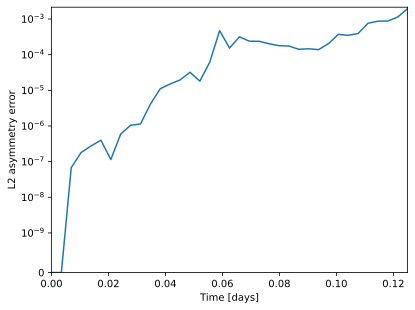

In [13]:
plt.plot(time_stamps, l2error)
plt.xlabel('Time [days]')
plt.ylabel('L2 asymmetry error')
plt.ylim(0, 1.1*np.max(l2error))
plt.xlim(0, time_stamps[-1])
plt.yscale('symlog', linthresh=1e-9)
plt.show()